In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
sns.set()
%matplotlib inline
import os

In [2]:
cc = pd.read_csv('cc_info.csv')
trans = pd.read_csv('transactions.csv', parse_dates=['date'])

In [3]:
trans.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 294588 entries, 0 to 294587
Data columns (total 5 columns):
credit_card                  294588 non-null int64
date                         294588 non-null datetime64[ns]
transaction_dollar_amount    294588 non-null float64
Long                         294588 non-null float64
Lat                          294588 non-null float64
dtypes: datetime64[ns](1), float64(3), int64(1)
memory usage: 11.2 MB


In [4]:
trans['year'] = trans['date'].transform(lambda x: x.year)
trans['month'] = trans['date'].transform(lambda x: x.month)
trans['day'] = trans['date'].transform(lambda x: x.day)
trans['hour'] = trans['date'].transform(lambda x: x.hour)

In [5]:
trans_month = trans.groupby(['credit_card', 'month'])['transaction_dollar_amount'].sum().unstack()
trans_month = trans_month.fillna(0)
trans_month['max_spent'] = trans_month.max(axis=1)
trans_month = trans_month.reset_index(level=['credit_card'])
trans_join = pd.merge(trans_month, cc, how='left', on='credit_card')

In [6]:
never_exceed = trans_join[trans_join.max_spent < trans_join.credit_card_limit]['credit_card']

# Alert function

In [7]:
def alert(trans, cc, month, day):
    #select transactions that start from the begining of the month to current day
    trans_current = trans[(trans.month == month) & (trans.day <= day)]
    
    #calculate the sum
    trans_current = trans_current.groupby('credit_card')['transaction_dollar_amount'].sum().to_frame().reset_index()
    #merge with card info to get card_limit
    trans_merge = pd.merge(trans_current, cc[['credit_card', 'credit_card_limit']], how = 'left', on ='credit_card')
    
    #check weather it exceeds the limit
    res = trans_merge[trans_merge.transaction_dollar_amount >= trans_merge.credit_card_limit]
    
    
    if res.shape[0] == 0:
        return 'No Alert'
    else:
        return res['credit_card'].to_frame().reset_index()
    
    

In [8]:
alert(trans, cc, 8, 20)

,index,credit_card
0,194,2850146878241916
1,319,3936887050542904
2,341,4118286032166087
3,383,4462290711836916
4,525,5723635641134781
5,698,7299183791723634
6,772,7850942767136368
7,834,8522875529951473
8,874,8972201384562696


# Unsupervised Learning

In [103]:
whole = pd.merge(trans, cc, on='credit_card', how='left')
#names = ['credit_card', 'transaction_dollar_amount', 'Long', 'Lat', 'month', 'day', 'hour']

#create transaction amount / credit limit feature
whole['limit_percent'] = whole['transaction_dollar_amount'] / whole['credit_card_limit']
whole['median_percent'] = whole.groupby('credit_card')['transaction_dollar_amount'].transform(lambda x: x/np.median(x))


#normalize Long and Lat by each card's median
whole['Long_norm'] = whole.groupby('credit_card')[['Long']].transform(lambda x: np.abs(x - np.median(x)))
whole['Lat_norm'] = whole.groupby('credit_card')[['Lat']].transform(lambda x: np.abs(x - np.median(x)))

In [111]:
whole['distance'] = np.sqrt(whole.Long_norm**2 + whole.Lat_norm**2)

In [112]:
whole.head()

,credit_card,date,transaction_dollar_amount,Long,Lat,year,month,day,hour,city,state,zipcode,credit_card_limit,limit_percent,median_percent,Long_norm,Lat_norm,distance
0,1003715054175576,2015-09-11 00:32:40,43.78,-80.174132,40.267370,2015,9,11,0,Houston,PA,15342,20000,0.002189,0.467086,0.036149,0.024456,0.043645
1,1003715054175576,2015-10-24 22:23:08,103.15,-80.194240,40.180114,2015,10,24,22,Houston,PA,15342,20000,0.005158,1.100501,0.016042,0.062801,0.064817
2,1003715054175576,2015-10-26 18:19:36,48.55,-80.211033,40.313004,2015,10,26,18,Houston,PA,15342,20000,0.002427,0.517977,0.000751,0.070090,0.070094
3,1003715054175576,2015-10-22 19:41:10,136.18,-80.174138,40.290895,2015,10,22,19,Houston,PA,15342,20000,0.006809,1.452897,0.036143,0.047981,0.060071
4,1003715054175576,2015-10-26 20:08:22,71.82,-80.238720,40.166719,2015,10,26,20,Houston,PA,15342,20000,0.003591,0.766243,0.028438,0.076195,0.081329


In [113]:
col_names = ['median_percent', 'distance']

train = whole[col_names]
train = train.transform(lambda x: (x-x.mean())/x.std())

train.describe()

,median_percent,distance
count,2.945880e+05,2.945880e+05
mean,-3.754160e-16,-3.473933e-15
std,1.000000e+00,1.000000e+00
min,-4.219491e-01,-1.150026e-01
25%,-2.230351e-01,-1.124090e-01
50%,-1.095584e-01,-1.113338e-01
75%,1.618741e-02,-1.105002e-01
max,4.067566e+01,1.938869e+01


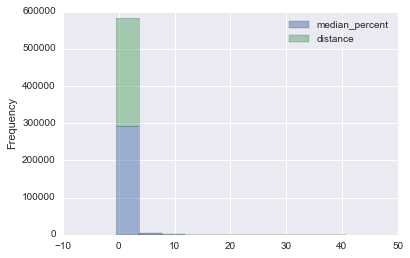

In [114]:
train.plot.hist(stacked=True, alpha=0.5)


(-1, 1)

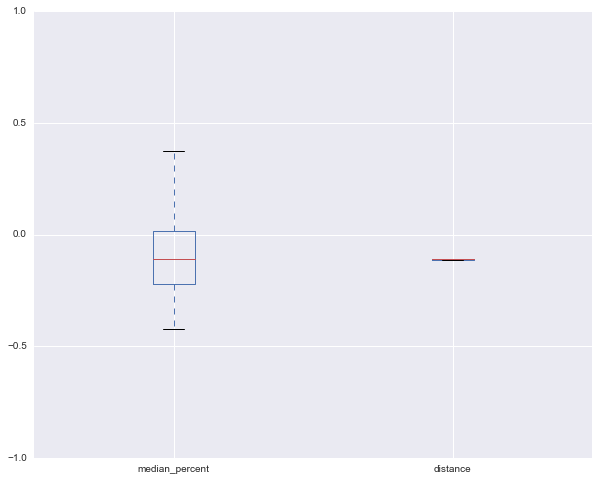

In [115]:
train.plot.box(figsize=(10, 8))
plt.ylim([-1, 1])

# train

In [116]:
from sklearn.cluster import KMeans
from sklearn.mixture import GaussianMixture, BayesianGaussianMixture
random_state = 7

In [117]:
n_train = train.shape[0]
km = KMeans(n_clusters=2)
km_pre = km.fit_predict(train)

print('number of potential fraud predicted by Kmeans: {}'.format(min(km_pre.sum(), n_train - km_pre.sum())))

number of potential fraud predicted by Kmeans: 4049


In [118]:
cov_type = ['full', 'tied', 'diag', 'spherical']

gm_pre_res = []
for cov in cov_type:
    gm = GaussianMixture(n_components=2, covariance_type=cov, random_state=random_state)
    gm.fit(train)
    gm_pre = gm.predict(train)
    
    gm_pre_res.append(gm_pre)
    print('covariance type: {}'.format(cov))
    print('number of potential fraud predicted by Gaussin Mixture: {}'.format(min(gm_pre.sum(), n_train - gm_pre.sum())))

covariance type: full
number of potential fraud predicted by Gaussin Mixture: 4208
covariance type: tied
number of potential fraud predicted by Gaussin Mixture: 4032
covariance type: diag
number of potential fraud predicted by Gaussin Mixture: 4208
covariance type: spherical
number of potential fraud predicted by Gaussin Mixture: 10052


In [119]:
cov_type = ['full', 'tied', 'diag', 'spherical']

bgm_pre_res = []
for cov in cov_type:
    bgm = BayesianGaussianMixture(n_components=2, covariance_type=cov, random_state=random_state)
    bgm.fit(train)
    bgm_pre = bgm.predict(train)
    bgm_pre_res.append(bgm_pre)
    print('covariance type: {}'.format(cov))
    print('number of potential fraud predicted by Bayesian Gaussin Mixture: {}'.format(min(bgm_pre.sum(), n_train - bgm_pre.sum())))

covariance type: full
number of potential fraud predicted by Bayesian Gaussin Mixture: 4208
covariance type: tied
number of potential fraud predicted by Bayesian Gaussin Mixture: 4032
covariance type: diag
number of potential fraud predicted by Bayesian Gaussin Mixture: 4208
covariance type: spherical
number of potential fraud predicted by Bayesian Gaussin Mixture: 10053


In [120]:
res = train
res['km_pre'] = km_pre
res['gm_pre_tied'] = gm_pre_res[1]

overlap = sum((res.km_pre == 1) & (res.gm_pre_tied == 1))
print('number of overlaps between kmeans and Gaussian mixture prediction {}'.format(overlap))

number of overlaps between kmeans and Gaussian mixture prediction 4032


In [142]:
#There is no need to sample points for plotting. seaborn can do the job pretty fast
# n_samples = 500

# pos_index = res[res.km_pre == 1].index
# pos_index_sample = np.random.choice(pos_index, size = n_samples, replace=False)
# pos_record = res.iloc[pos_index_sample]
# print('positive recorde shape: {}'.format(pos_record.shape))

# neg_index = res[res.km_pre == 0].index
# neg_index_sample = np.random.choice(neg_index, size = n_samples, replace=False)
# neg_record = res.iloc[neg_index_sample]
# print('negative recorde shape: {}'.format(neg_record.shape))

# samples = pd.concat([pos_record, neg_record], axis = 0)

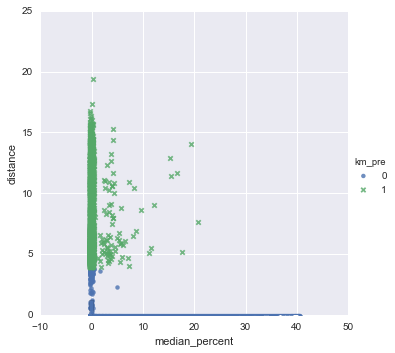

In [146]:
sns.lmplot('median_percent', 'distance', data = res, fit_reg=False, hue='km_pre',
          markers=['o', 'x']);

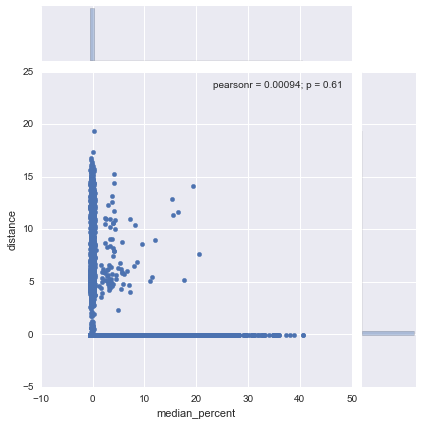

In [149]:
sns.jointplot(x='median_percent', y = 'distance', data = res)

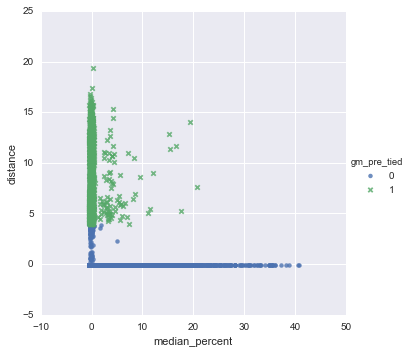

In [145]:
sns.lmplot('median_percent', 'distance', data = res, fit_reg=False, hue='gm_pre_tied',
          markers=['o', 'x']);

In [150]:
res.describe()

,median_percent,distance,km_pre,gm_pre_tied
count,2.945880e+05,2.945880e+05,294588.000000,294588.000000
mean,-3.754160e-16,-3.473933e-15,0.013745,0.013687
std,1.000000e+00,1.000000e+00,0.116429,0.116188
min,-4.219491e-01,-1.150026e-01,0.000000,0.000000
25%,-2.230351e-01,-1.124090e-01,0.000000,0.000000
50%,-1.095584e-01,-1.113338e-01,0.000000,0.000000
75%,1.618741e-02,-1.105002e-01,0.000000,0.000000
max,4.067566e+01,1.938869e+01,1.000000,1.000000
